In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

In [26]:
db=mysql.connector.connect(
    host="localhost",
    username="root",
    password="pass123",
    database="ecommerce"
)

curr=db.cursor()

1. List all unique cities where customers are located.

In [36]:
query="""select distinct(customer_city) from customers"""

curr.execute(query)

data=curr.fetchall()
df=pd.DataFrame(data,columns=["City"])
df.head(5)

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. Count the number of order placed in 2017.

In [10]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

curr.execute(query)

data=curr.fetchall()
data

[(90202,)]

3. Find the total sales per category.

In [6]:
query="""select products.product_category as category,round(sum(payments.payment_value),2)
  from products join order_items
  on products.product_id=order_items.product_id
  join payments
  on payments.order_id=order_items.order_id
  group by category
"""
curr.execute(query)
data=curr.fetchall()

df=pd.DataFrame(data,columns=['Category','Sales'])
df



,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


4. Calculate the percentage of orders that were paid in installment.

In [15]:
query="""select (sum(case when payment_installments>=1 then 1 
else 0 end))/count(*)*100 from payments"""

curr.execute(query)
data=curr.fetchall()
data


[(Decimal('99.9981'),)]

5. Count the number of customer from each  state.

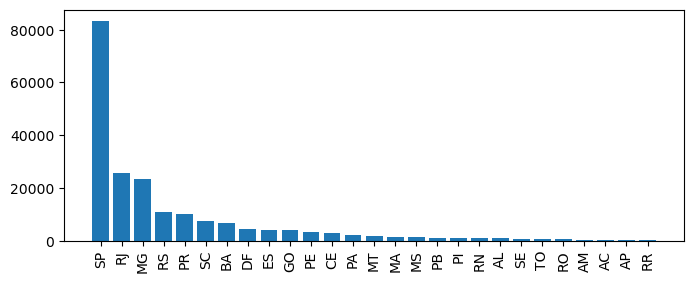

In [32]:
query="""select customer_state ,count(customer_id) 
from customers group by customer_state
"""
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=["State","Total Customer"])

## sort the value
df=df.sort_values(by="Total Customer",ascending=False)

## Resize the Figure
plt.figure(figsize=(8,3))

plt.bar(df["State"],df["Total Customer"])
plt.xticks(rotation=90)
plt.show()

## Intermediate Queries

6. Calculate the number of orders per month in 2018

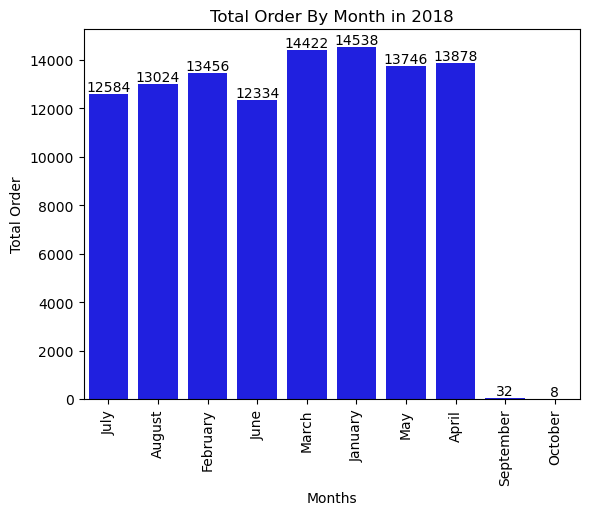

In [55]:
query="""select monthname(order_purchase_timestamp) as months, count(order_id) 
from orders where year(order_purchase_timestamp)=2018
group by months"""
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data, columns=["Months","Total Order"])

ax=sns.barplot(x=df['Months'],y=df['Total Order'], data=df, color="Blue")
plt.xticks(rotation=90)

## Add the level on the graph
ax.bar_label(ax.containers[0])
## Add title of the graph
plt.title("Total Order By Month in 2018")
plt.show()


7. Find the average number of product per order, grouped by customer city.

In [57]:
query="""with count_per_order as
(select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
 from Orders join order_items
 on orders.order_id=order_items.order_id
 group by orders.order_id,orders.customer_id)
 
 select customers.customer_city, avg(count_per_order.oc)
 from customers join count_per_order
 on customers.customer_id=count_per_order.customer_id
 group by customers.customer_city;
"""
curr.execute(query)
data=curr.fetchall()
# data
df=pd.DataFrame(data)
df.head()

,0,1
0,treze tilias,2.5455
1,indaial,2.2308
2,sao jose dos campos,2.2770
3,sao paulo,2.3124
4,porto alegre,2.3499


8. Calculate the percentage of total revenue contributed by each product category. 

In [69]:
query="""select products.product_category as category,(sum(payments.payment_value)/(select sum(payment_value) from payments))*100
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category

"""
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=["Category","percentage_per_category"])
df.head()

,Category,percentage_per_category
0,perfumery,3.165361
1,Furniture Decoration,8.933649
2,telephony,3.041326
3,bed table bath,10.697529
4,automotive,5.323887


9. Identify the correlation between product price and the number of times a product has been purchased.

In [13]:
query="""select products.product_category,
count(order_items.product_id),
Round(avg(Order_items.price),2)
from products join Order_items
on products.product_id=Order_items.product_id
group by products.product_category
"""

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=["Product Category","No of Orders","Total price"])
# df

##corelation Between 
arr1=df["No of Orders"]
arr2=df["Total price"]
np.corrcoef([arr1,arr2])


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

10. Calculate the total revenue generated by each seller, and rank then by revenue.

<function matplotlib.pyplot.show(close=None, block=None)>

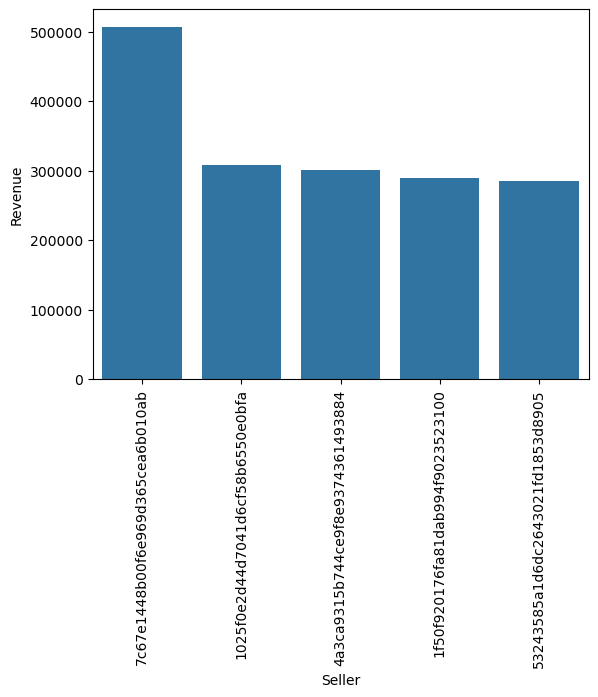

In [23]:
query="""select *,dense_rank() over (order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value) as revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a
"""
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=["Seller","Revenue","Rank"])
df=df.head()
sns.barplot(x="Seller",y="Revenue",data=df)
plt.xticks(rotation=90)
plt.show

## Advanced Queries

11. Calculate the moving average of order values for each customer over their order history.

In [28]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a"""

curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data)
df.head(10)

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
5,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
6,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
7,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
8,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
9,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


12. Calculate the cumulative sales per month for each year.

In [10]:
query=""" select years,months,payment,sum(payment)
over(order by years,months) from
(select year(orders.order_purchase_timestamp)as years,
 month(order_purchase_timestamp) as months,
 round(sum(payments.payment_value),2) as payment
 from orders join payments
 on orders.order_id=payments.order_id
 group by years,months order by years, months) as a
"""
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=["Years","Months","payment","Cumulative Sales"])
df

,Years,Months,payment,Cumulative Sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


13. Calculate the year-over-year growth rate of total sales.

In [22]:
query="""with a as (select year(orders.order_purchase_timestamp) as Years,
round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id=payments.order_id
group by Years order by Years)

select Years, payment,(((payment-lag(payment,1) over(order by Years)))/
lag(payment,1) over(order by Years))*100 from a 
"""
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=["Year","payment","YOY % growth"])
df

,Year,payment,YOY % growth
0,2016,118724.68,NaN
1,2017,14499493.46,12112.703761
2,2018,17399526.10,20.000924


14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of theri first purchase.

In [24]:
query="""with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) as next_order
from a join orders
on a.customer_id=orders.customer_id
and orders.order_purchase_timestamp>first_order
and orders.order_purchase_timestamp< date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id=b.customer_id
"""
curr.execute(query)
data=curr.fetchall()
data

[(None,)]

15. Identify the top 3 customers who spent the most money in each year.

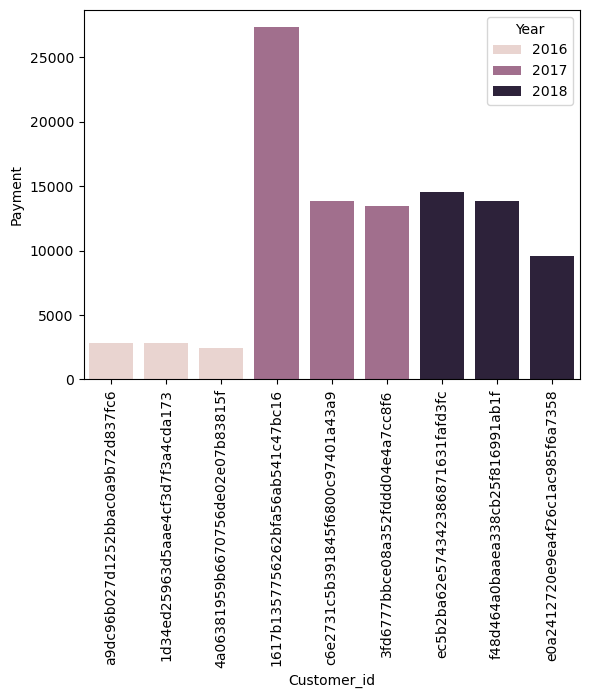

In [44]:
query="""select Years, customer_id,payment,d_rank from
(select year(orders.order_purchase_timestamp) as Years,
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as d_rank
from orders join payments
on orders.order_id=payments.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank<=3
"""
curr.execute(query)
data=curr.fetchall()
df=pd.DataFrame(data,columns=["Year","Customer_id","Payment","Rank"])
# df
sns.barplot(x="Customer_id", y="Payment", data=df, hue="Year")
plt.xticks(rotation=90)
plt.show()